# 🍔 Multivariate Testing - Fast Food Marketing

## 0. Overview

In this notebook we are conducting statistical analysis and A/B Multivariate testing for a Fast Food Marketing Campaign its **3 possible marketing promotions**. There is a new fast food item being introduced and we are interested in **which promotion would see an increase in sales** revenue. 

**🎯 Objective:**

Compare sales amounts between 3 different promotion tactics. Which promotion has the greatest increasing effect on sales? 

### 0.1 Hypotheses and Metrics

* **H₀** (null hypothesis) - the 3 promotion tactics have the same effectivity for sales of the new item.
* **Hₐ** (alternative hypothesis) - there is a significant difference  in the effectivity of the 3 promotions. 

* **Target metric**- Sales amount *(SalesInThousands)*

Dataset taken from [Kaggle](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test)

### 0.2 Importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chisquare

%matplotlib inline
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context(
    "notebook",
    rc={"axes.titlesize": 14, "axes.titleweight": "bold", "axes.labelsize": 11})
trio_palette = ['firebrick', 'darkorange', 'gold']

Loading dataset

In [2]:
file_path = "dataset/WA_Marketing-Campaign.csv"
df_import = pd.read_csv(file_path, header=0)
df = df_import.copy()

### 0.3 Dataset Overview

#### Feature Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


There are 548 data entries

**Features:**
* **MarketID**: unique identifier for market
* **MarketSize**: size of market area by sales
* **LocationID**: unique identifier for store location
* **AgeOfStore**: age of store in years
* **Promotion**: one of three promotions that were tested
* **week**: one of four weeks when the promotions were run
* **SalesInThousands**: sales amount for a specific LocationID, Promotion, and week

#### Dataframe Preview

In [4]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## 🧹 1. Data Cleaning

#### 1.1 Check for null or duplicate values

In [5]:
print("Null values in the df: ", df.isna().sum().sum())
print("Duplicate values in the df: ", df.duplicated().sum())

Null values in the df:  0
Duplicate values in the df:  0


There are no null or duplicate values detected

#### 1.2 Check for anomalies in discrete features
Are there unique values besides the supposed discrete options?

In [6]:
for col in df.columns:
    unique_vals = df[col].unique()
    display_vals = unique_vals[:10]
    suffix = "..." if len(unique_vals) > 10 else ""
    print(f"{col}: {display_vals}{suffix}\n")

MarketID: [ 1  2  3  4  5  6  7  8  9 10]

MarketSize: ['Medium' 'Small' 'Large']

LocationID: [ 1  2  3  4  5  6  7  8  9 10]...

AgeOfStore: [ 4  5 12  1 10 15  6 22  8 19]...

Promotion: [3 2 1]

week: [1 2 3 4]

SalesInThousands: [33.73 35.67 29.03 39.25 27.81 34.67 27.98 27.72 44.54 37.94]...



There are no anomalies in discrete data values

### 1.3 Treating Outliers

Text(0.5, 1.0, 'Age Distribution')

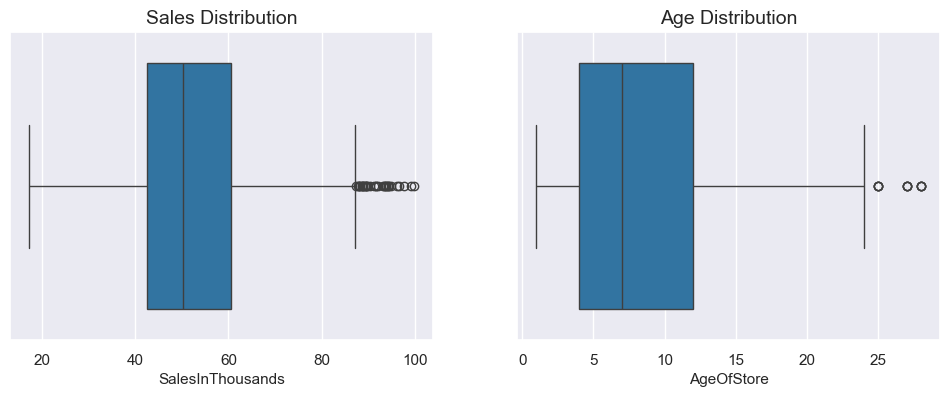

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(df, x='SalesInThousands', ax=axes[0])
axes[0].set_title('Sales Distribution')

sns.boxplot(df, x='AgeOfStore', ax=axes[1])
axes[1].set_title('Age Distribution')

- In both features of Age and Sales, outliers are of the higher regard
    - Outliers in age are older stores
    - Outliers in sales are higher earning stores

In [8]:
# Select only the continuous variables for outlier detection
num_cols = df[["AgeOfStore", "SalesInThousands"]]

# Calculate Q1, Q3, and IQR
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (num_cols < lower_bound) | (num_cols > upper_bound)

outlier_values = num_cols[outliers].stack().reset_index()
outlier_values.columns = ["idx", "features", "value"]

outlier_grouped = outlier_values.groupby("idx").agg({
    "features": list,
    "value": list
}).reset_index()
outlier_grouped = outlier_grouped.sort_values(by='value', ascending=False)
print(outlier_grouped.head())


    idx            features    value
26  144  [SalesInThousands]  [99.65]
30  154  [SalesInThousands]  [99.12]
15  111  [SalesInThousands]  [97.61]
10  104  [SalesInThousands]  [96.48]
13  109  [SalesInThousands]  [96.01]


In [9]:
print("Outlier value count: ", len(outlier_values))
percent_outliers = (len(outlier_values) / len(df)) * 100
print(f"Percent of outliers: {percent_outliers:.2f}%")

Outlier value count:  45
Percent of outliers: 8.21%


- 45 Outliers contribute to ~8% of the data
- We will keep these outliers as they simply represent higher earning stores and older stores, but are not concerning anomalies

## 2. Analysis

**Visual Guide** \
In the theme of fast food and appetite, this notebook will be using a Red, Orange, and Yellow (ROY) per Promotion, a color palette known to be related to food and appetite.
* 🟥 Promotion 1 - Red 
* 🟧 Promotion 2 - Orange 
* 🟨 Promotion 3 - Yellow 

### 2.1 Sample Ratio Mismatch (SRM) Check

In [10]:
counts = df["Promotion"].value_counts().sort_index()
counts

Promotion
1    172
2    188
3    188
Name: count, dtype: int64

In [11]:
labels = [f'Promotion {i}' for i in counts.index]

fig = go.Figure(go.Pie(labels=labels, 
                       values=counts, 
                       marker=dict(colors=trio_palette),
                       textinfo='label+percent'))
fig.update_layout(title='Proportions between Promotions')
fig.show()

#### Chi-square goodness-of-fit Testing for SRM

Compares observed vs. expected counts - expected being an equal amount between two groups

We must mathematically check for Sample Ratio Mismatch (SRM) between the three promotion subsets.

To do so, for this section, we will be observing another pair of hypotheses:
* **H₀** : The three groups are balanced. There is no sample ratio mismatch detected.
* **Hₐ** : The three groups are not balanced. There is a significant mismatch.

We will be using a stricter significance threshhold (α) that is more commonplace for SRM (SRM is a sensitive value): 
* **α = 0.01**

In [12]:
observed = counts.values

expected = [observed.sum() / len(observed)] * len(observed)

Expected counts being an even split between the data

In [13]:
chi, p_value = chisquare(f_obs=observed, f_exp=expected)
print("Chi-squared statistic:", chi)
print("p-value:", p_value)

if p_value <= 0.01:
    print("Conclusion: Warning - SRM may be present.")
else:
    print("Conclusion: SRM not likely.")

Chi-squared statistic: 0.9343065693430658
p-value: 0.6267840066678985
Conclusion: SRM not likely.


**p 0.62 > α 0.01**

The p-value 0.62 is much greater than α 0.01, so it is not below our significance threshold.
* This gives us high confidence that:
    * SRM is extremely unlikely
    * The AB test **passes the SRM check through chi-squared testing**

### 2.2 Distribution

To help make decisions on our route of A/B testing, the distribution of the data must be observed

In [14]:
mean = df["SalesInThousands"].mean()
median = df["SalesInThousands"].median()
mode = df["SalesInThousands"].mode()[0]

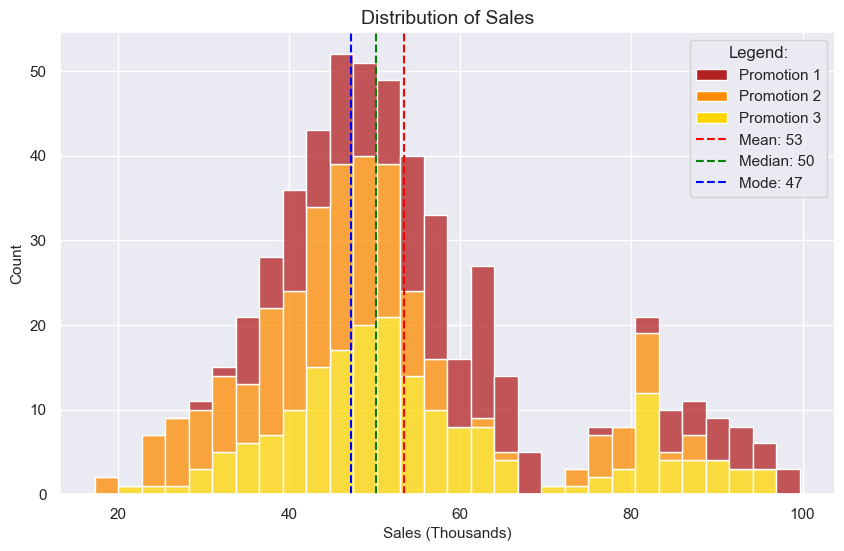

In [15]:
plt.figure(figsize=(10, 6))

sns.histplot(
    df,
    x="SalesInThousands",
    hue="Promotion",
    multiple="stack",
    stat="count",
    bins=30,
    palette=trio_palette
)

mean_line = plt.axvline(mean, color="red", linestyle="--")
median_line = plt.axvline(median, color="green", linestyle="--")
mode_line = plt.axvline(mode, color="blue", linestyle="--")

label_icons = [
    Patch(facecolor=trio_palette[0]),
    Patch(facecolor=trio_palette[1]),
    Patch(facecolor=trio_palette[2]),
    Line2D([0], [0], color="red", linestyle="--"),
    Line2D([0], [0], color="green", linestyle="--"),
    Line2D([0], [0], color="blue", linestyle="--"),
]

custom_labels = [
    "Promotion 1",
    "Promotion 2",
    "Promotion 3",
    f"Mean: {mean:.0f}",
    f"Median: {median:.0f}",
    f"Mode: {mode:.0f}",
]
plt.legend(handles=label_icons, labels=custom_labels, title="Legend:")

plt.title("Distribution of Sales")
plt.xlabel("Sales (Thousands)");

**Mean, Median, Mode:**
* Mean: Average sales are 53k, this mean is being pulled to the right by the skewed tail.
* Median: Middle point of the distribution is 50,000 sales. 50% of stores sell lower and 50% sell higher than this respectively.
* Mode: The most common point of sales is 47,000.

**Promotions:**

It is visually noticeable that **Promotion 1** has higher sales than the other 2 campaigns.

**Distribution: Right-skewed**
* Sales are positively skewed
* Distribution has a long tail to the right, composed of the upper sales outliers seen earlier

## 3. Statistical Testing

With skewed data, we will be observing the **median** since the mean can be heavily influenced by the right-skewed sales.

**Observations:**
* Working with multivariate data (3 promotions)
* Continuous metric (Sales)
* Not a normal distribution of data (Right-skewed)

These observations line up with the assumptions of the **Kruskal-Wallis H-test**.

### 3.1 Kruskal-Wallis test

Answers the question: Is there a significant difference between sales of the 3 promotions?

Assumptions of the Kruskal-Wallis test:
* This test allows us to test more than 2 independent samples (3 promotions)
* This test does not require normality, discrete variables or equal variances.
* It observes the null hypothesis that the median of all the groups are equal. 
    * H₀ - the median sales are the same across all 3 promotions
    * Hₐ - promotions have different median sales.

In [16]:
from scipy.stats import kruskal

group1 = df[df['Promotion'] == 1]['SalesInThousands']
group2 = df[df['Promotion'] == 2]['SalesInThousands']
group3 = df[df['Promotion'] == 3]['SalesInThousands']

stat, p = kruskal(group1, group2, group3)
print('H-statistic: ', stat)
print(f'p-value: {p:.20f}')

H-statistic:  53.29475169322799
p-value: 0.00000000000267418663


p < α 0.05

The Kruskal-Wallis test returns a p-value exponentially smaller than our threshhold.

This suggests that at least one promotion has significantly different median sales.

While we know a significant difference exists between the promotions, to uncover which specific groups are different we will use a Dunn's test which complements the Kruskal-Wallis test:

### 3.2 Dunn's Test

Answers the question: Which promotions are different between each other?

* Running pairwise comparisons
* Bonferonni adjustment to adjust p-values for multiple testing

In [17]:
import scikit_posthocs as sp

dunn_results = sp.posthoc_dunn(
    df, 
    val_col='SalesInThousands', 
    group_col='Promotion', 
    p_adjust='bonferroni'
)

print("Dunn's post-hoc test results (p-values):")
print(dunn_results)

Dunn's post-hoc test results (p-values):
              1             2             3
1  1.000000e+00  6.461842e-12  1.458660e-01
2  6.461842e-12  1.000000e+00  7.083069e-07
3  1.458660e-01  7.083069e-07  1.000000e+00


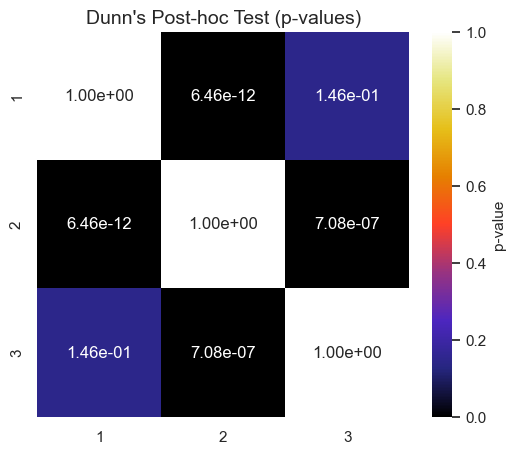

In [18]:
alpha = 0.05

plt.figure(figsize=(6,5))
sns.heatmap(
    dunn_results,
    annot=True,                   
    fmt='.2e',                     
    cmap='CMRmap',             
    cbar_kws={"label": "p-value"}
)
plt.title("Dunn's Post-hoc Test (p-values)")
plt.show()

| Promotion Pair       | p-value       | Significance     |
|-----------------|---------------|----------------|
| Promotion 1 vs 2 | 6.46e-12     | Significant     |
| Promotion 1 vs 3 | 0.146        | Not Significant |
| Promotion 2 vs 3 | 7.08e-07     | Significant     |

The Dunn's post-hoc test showed that **Promotion 1 vs. Promotion 2, and Promotion 2 vs. Promotion 3, has significantly different sales.**

Meanwhile Promotion 1 and 3 are not significantly different.

### 3.3 Median Sales Comparison

Answers the question: Which specific promotions have higher and lower sales?

It is understood that there are different sales between the promotions - which sales are higher and which are lower?

To visualize the magnitude of difference and more importantly, the direction of sales (higher or lower) between these groups, we will refer to a box plot:

Text(0.5, 1.0, 'Promotion Distributions')

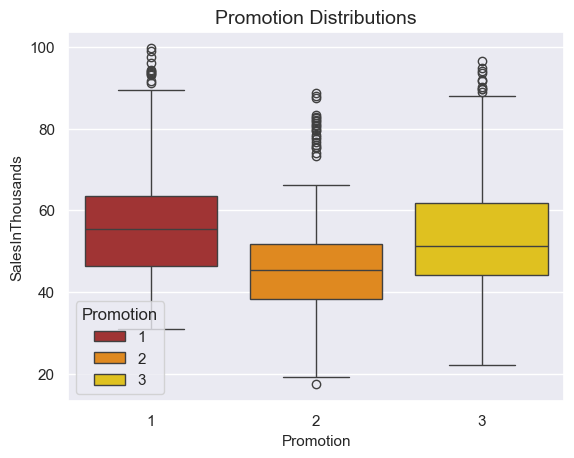

In [19]:
sns.boxplot(df, y='SalesInThousands', x='Promotion', hue='Promotion', palette=trio_palette)

plt.title("Promotion Distributions")

**Promotion 1 has the highest performing median sales**, 3 is secondary and Promotion 2 is the weakest performing.

### 3.4 Confidence Intervals
#### 3.4.1 Bootstrapping & Resampling

In this section we aim to calculate the range of uncertainty around our given estimated medians. We will be computing **95%** confidence intervals.

To do so, we will use **bootstrapping** to resample and create simulated subsets of the data, allowing us to approximate the distribution of the median.

In [20]:
def bootstrap_median(original_sample, label, replications):
    """
    Simulate sample medians
    Returns: array of bootstrapped sample medians
    """
    medians = np.array([])
    n = len(original_sample)

    for i in np.arange(replications):
        bootstrap_sample = original_sample.sample(n, replace=True)
        resampled_median = bootstrap_sample[label].median()
        medians = np.append(medians, resampled_median)

    return medians

In [21]:
alpha = 0.05
replications = 1000

results = []
for promo, row in df.groupby('Promotion'):
    boot_medians = bootstrap_median(row, 'SalesInThousands', replications)
    median = np.median(boot_medians)
    ci_lower = np.percentile(boot_medians, 100 * alpha / 2)
    ci_upper = np.percentile(boot_medians, 100 * (1 - alpha / 2))
    results.append([promo, median, ci_lower, ci_upper])

df_bootstrap = pd.DataFrame(results, columns=['promotion', 'median', 'ci_lower', 'ci_upper']).round(2)
df_bootstrap

,promotion,median,ci_lower,ci_upper
0,1,55.31,53.60,57.20
1,2,45.39,44.16,47.28
2,3,51.16,50.02,53.14


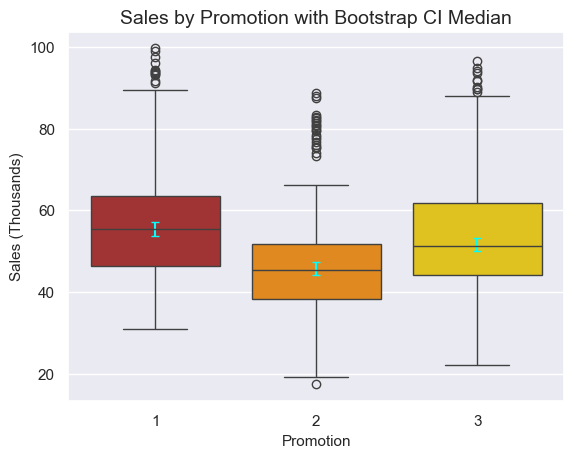

In [22]:
sns.boxplot(df, x='Promotion', hue='Promotion', y='SalesInThousands', palette=trio_palette)

for i, row in df_bootstrap.iterrows():
    median = row['median']
    lower = row['ci_lower']
    upper = row['ci_upper']
    
    yerr = [[median - lower], [upper - median]]
    plt.errorbar(i, median, yerr=yerr, fmt='none', color='aqua', capsize=3)

plt.title('Sales by Promotion with Bootstrap CI Median')
plt.ylabel('Sales (Thousands)')
plt.xlabel('Promotion')
plt.legend().remove()
plt.show()

The 95% Confidence Intervals do not go beyond 2 values off the calculated medians.

#### 3.4.2 Confidence Intervals through Rank-Based medians

To compare how bootstrapping calculated our Confidence Intervals, we will observe another method:
- Rank-based CI / Order-Statistic CI / Non-parametric CI

In [23]:
from scipy.stats import binom

# Function to compute rank-based 95% CI for the median
def median_ci_order_statistic(values, alpha=0.05):
    n = len(values)
    sorted_vals = np.sort(values)
    
    # Compute order statistic indices
    k1 = int(np.ceil(binom.ppf(alpha / 2, n, 0.5)))
    k2 = int(np.floor(binom.ppf(1 - alpha / 2, n, 0.5)))
    
    # Ensure indices are within bounds
    k1 = max(k1, 0)
    k2 = min(k2, n - 1)
    
    return sorted_vals[k1], sorted_vals[k2]

# Group by Promotion and compute median + CI
results = []
for promo, group_df in df.groupby("Promotion"):
    sales = group_df["SalesInThousands"]  # select column inside loop
    median_val = np.median(sales)
    ci_lower, ci_upper = median_ci_order_statistic(sales, alpha=0.05)
    results.append([promo, median_val, ci_lower, ci_upper])

df_rank_ci = pd.DataFrame(results, columns=["Promotion", "median", "ci_lower", "ci_upper"]).round(2)
df_rank_ci

,Promotion,median,ci_lower,ci_upper
0,1,55.39,53.53,57.20
1,2,45.39,44.16,47.33
2,3,51.16,50.05,53.14


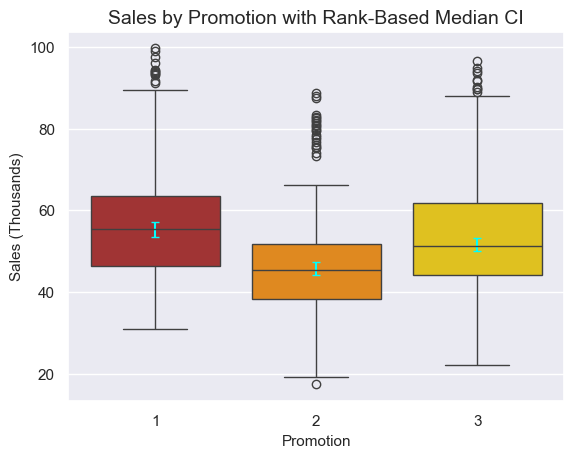

In [24]:
sns.boxplot(df, x='Promotion', hue='Promotion', y='SalesInThousands', palette=trio_palette)

for i, row in df_rank_ci.iterrows():
    median = row['median']
    lower = row['ci_lower']
    upper = row['ci_upper']
    yerr = [[median - lower], [upper - median]]
    plt.errorbar(i, median, yerr=yerr, fmt='none', color='aqua', capsize=3)


plt.title('Sales by Promotion with Rank-Based Median CI')
plt.ylabel('Sales (Thousands)')
plt.xlabel('Promotion')
plt.legend().remove()
plt.show()

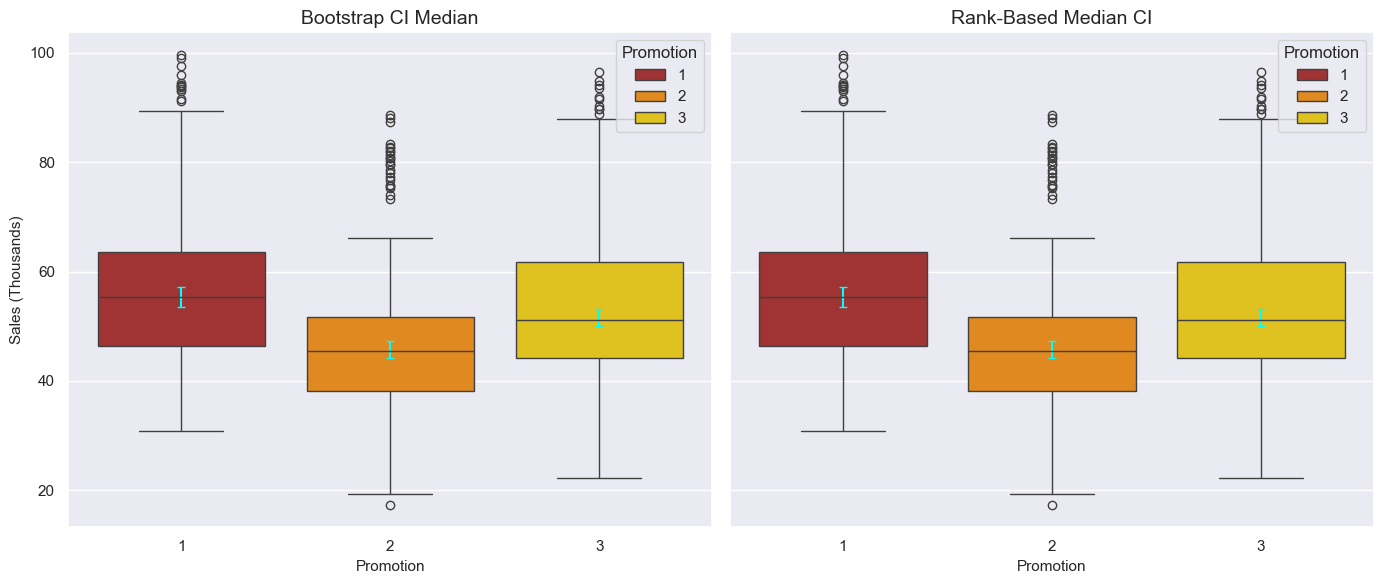

Bootstrapped CIs:
   promotion  median  ci_lower  ci_upper
0          1   55.31     53.60     57.20
1          2   45.39     44.16     47.28
2          3   51.16     50.02     53.14

Rank-Based CIs:
   Promotion  median  ci_lower  ci_upper
0          1   55.39     53.53     57.20
1          2   45.39     44.16     47.33
2          3   51.16     50.05     53.14


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True) 

# Bootstrapped plot
sns.boxplot(df, x='Promotion', hue='Promotion', y='SalesInThousands', palette=trio_palette, ax=axes[0])

for i, row in df_bootstrap.iterrows():
    median = row['median']
    lower = row['ci_lower']
    upper = row['ci_upper']
    
    yerr = [[median - lower], [upper - median]]
    axes[0].errorbar(i, median, yerr=yerr, fmt='none', color='aqua', capsize=3)

axes[0].set_title('Bootstrap CI Median')
axes[0].set_ylabel('Sales (Thousands)')
axes[0].set_xlabel('Promotion')

# 2. Rank-based CI plot
sns.boxplot(df, x='Promotion', hue='Promotion', y='SalesInThousands', palette=trio_palette, ax=axes[1])

for i, row in df_rank_ci.iterrows():
    median = row['median']
    lower = row['ci_lower']
    upper = row['ci_upper']
    yerr = [[median - lower], [upper - median]]
    plt.errorbar(i, median, yerr=yerr, fmt='none', color='aqua', capsize=3)

axes[1].set_title('Rank-Based Median CI')
axes[1].set_ylabel('Sales (Thousands)')
axes[1].set_xlabel('Promotion')

plt.tight_layout()
plt.show()
print("Bootstrapped CIs:")
print(df_bootstrap)

print("\nRank-Based CIs:")
print(df_rank_ci)

In both methods, whether bootstrapped or rank-based, the median stayed the same. This shows that the data's median is robust and not sensitive to the methods applied.

Both returned nearly identical intervals. There are only marginal differences in the calculated confidence intervals. Rank-based return slightly higher upper values (again, only barely) 

In [27]:
df = pd.read_csv("dataset/WA_Marketing-Campaign.csv")

median_weekly = (
    df.groupby(['week', 'Promotion'])['SalesInThousands']
    .median()
    .reset_index()
    .rename(columns={'SalesInThousands': 'median_sales'})
)

median_weekly.to_csv(r"dataset/median_weekly.csv", index=False)

## 4. Conclusion
**Data**:
* Distribution of data is skewed, with a right tail consisting of high sales.
* Target metric is continuous: Sales
* The above leads us to choosing the chi-squared test of independence, with the following results:
    * p-value of 0.02 is below our threshold of 0.05


**Retention Rates** and our **A/B testing results**:
* We reject our null hypothesis that the gates have the same player retention. 
* Gate 30 has a statistically significant higher rate of retention
    * Conclusive that players gravitate to the earlier checkpoint as a faster incentive
    * The Cookie Cats team should keep the first gate in the game as Gate 30 

Goal. Based on the dataset description in Kaggle, describe the goal of the A/B test. Give any necessary context.
Target metric. Choose a target metric and describe how it measures progress towards the stated goal of the A/B test.
Calculations.

Some tips:

There are several statistical tests that you might need during this project - Student’s t-test, binomial test and the chi-square test. Here are some good resources on them:
Student’s t-test and Scipy documentation
Chi-square test and Scipy documentation
For statistical tests, feel free to check your numbers against those given by the Evan Miller A/B Test Calculator.
You will notice that the number of samples in each variant is not the same. Some discrepancy should be expected due to randomness, but large differences, when they are not expected, are a symptom of a bug in the way units were randomized. This is known as sample ratio mismatch (SRM). Before proceeding with the analysis of the test, test for sample ratio mismatch using the chi-square test.

- In your notebook, aggregate and prepare data as needed. Report key information about the A/B test, including the sample size and variant proportions.
- Conduct statistical tests. Describe which test you have chosen for each metric and why.
- Report the estimated treatment effect, confidence interval and p-value. For one of the datasets, compute the confidence interval both analytically and using bootstrap and report both intervals.
- Decision. Describe clearly what your calculations imply and which decision you recommend. Use visualizations to show differences in the metric between groups and confidence intervals.


In addition to the notebooks, create a dashboard with at least two plots. One of the plots should illustrate how the target metric changes across the weeks in the Fast Food Marketing Campaign A/B test.
